In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [2]:
sns.set_style('ticks')
sns.set_context('notebook')

In [3]:
def silverman_rot(sample):
    """Calculates the Silverman's rule-of-thumb bandwidth for the given
    sample.
    
    Args:
        sample (list or np.ndarray): array of data points
        
    Returns:
        float: rule-of-thumb bandwidth
    """
    iqr = np.percentile(sample, 75) - np.percentile(sample, 25)
    sigma = np.std(sample)
    return 0.9 * min(iqr/1.34, sigma) * len(sample)**(-0.2)

In [4]:
np.random.seed(0)
enorm = stats.exponnorm(2)
obs = enorm.rvs(size=250).reshape(-1, 1)
n_split = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.geomspace(0.1, 3, 20)}, cv=n_split)
grid.fit(obs)
kde_narrow = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(obs)
kde_right = grid.best_estimator_
kde_wide = KernelDensity(kernel='gaussian', bandwidth=3).fit(obs)
kde_rot = KernelDensity(kernel='gaussian', bandwidth=silverman_rot(obs)).fit(obs)

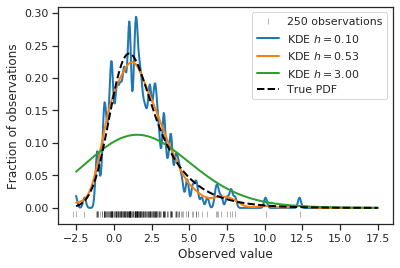

In [5]:
# plt.hist(obs, density=True, bins=25, alpha=0.2, color='k')
plt.plot(obs, [-0.01]*len(obs), '|', color='k', alpha=0.3, label='{} observations'.format(len(obs)))
x = np.linspace(-2.5, 17.5, 500)
for i, kde in enumerate([kde_narrow, kde_rot, kde_wide]):
    plt.plot(x, np.exp(kde.score_samples(x.reshape(-1, 1))),
             label='KDE $h={:0.2f}$'.format(kde.bandwidth), color='C'+str(i), linewidth=2)
plt.plot(x, enorm.pdf(x), linewidth=2, color='k', label='True PDF', linestyle='--')
plt.xlabel('Observed value')
plt.ylabel('Fraction of observations')
plt.legend()
plt.savefig('../figures/1d_hist_example.pdf', bbox_inches='tight')

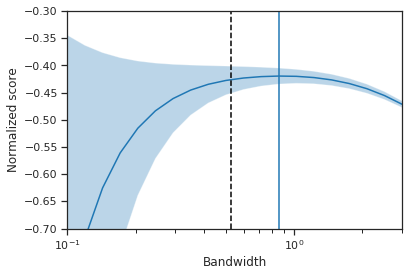

In [6]:
plt.plot([x['bandwidth'] for x in grid.cv_results_['params']],
         grid.cv_results_['mean_test_score']/len(obs))
plt.fill_between([x['bandwidth'] for x in grid.cv_results_['params']],
                 (grid.cv_results_['mean_test_score']+grid.cv_results_['std_test_score'])/len(obs),
                 (grid.cv_results_['mean_test_score']-grid.cv_results_['std_test_score'])/len(obs),
                 alpha=0.3)
plt.xlim(grid.cv_results_['params'][0]['bandwidth'], grid.cv_results_['params'][-1]['bandwidth'])
plt.ylim(-0.7, -0.3)
plt.axvline(grid.best_estimator_.bandwidth)
plt.axvline(silverman_rot(obs), color='k', linestyle='--')
plt.xscale('log')
plt.xlabel('Bandwidth')
plt.ylabel('Normalized score')
plt.savefig('../figures/1d_bandwidth_example.pdf', bbox_inches='tight')
# for split in range(n_split):
#     plt.plot([x['bandwidth'] for x in grid.cv_results_['params']],
#              grid.cv_results_['split{}_test_score'.format(split)]/len(obs))

In [7]:
grid.best_estimator_.bandwidth

0.8568773973458867

# 2d case

In [8]:
np.random.seed(0)
covxy = -3.
multinorm = stats.multivariate_normal(cov=[[1., covxy], [covxy, 16.]])
obs = multinorm.rvs(size=250)

n_split = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.geomspace(0.1, 3, 20)}, cv=n_split)
grid.fit(obs)
kde_narrow = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(obs)
kde_right = grid.best_estimator_
kde_wide = KernelDensity(kernel='gaussian', bandwidth=3).fit(obs)

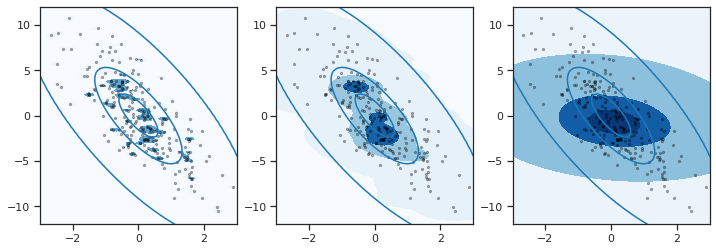

In [9]:
x = np.linspace(-6, 6, 100)
y = np.linspace(-12, 12, 100)
X, Y = np.meshgrid(x, y)
Z = multinorm.pdf(np.dstack((X, Y)))
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(12, 4))
kdes = [kde_narrow, kde_right, kde_wide]
for i, kde in enumerate(kdes):
    plt.subplot(1, len(kdes), i+1)
    Z_kde = 10**kde.score_samples(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
    levels_kde = [0,
                  np.percentile(Z_kde.flatten(), 68),
                  np.percentile(Z_kde.flatten(), 95),
                  np.percentile(Z_kde.flatten(), 99),
                  np.max(Z_kde)]
    plt.contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
    plt.contour(X, Y, Z, levels, colors='C0')
    plt.scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
    plt.xlim(-3, 3)
    plt.ylim(-12, 12)

## Non-Gaussian example

In [10]:
np.random.seed(0)
obsx = enorm.rvs(size=250)
obsy = np.tanh(obsx) + stats.norm.rvs(scale=0.75, size=250)

obs = np.array([obsx, obsy]).T
n_split = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.geomspace(0.1, 3, 20)}, cv=n_split)
grid.fit(obs)
kde_narrow = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(obs)
kde_right = grid.best_estimator_
kde_wide = KernelDensity(kernel='gaussian', bandwidth=3).fit(obs)

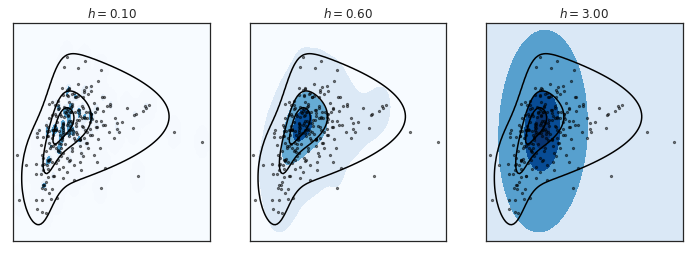

In [11]:
x = np.linspace(-3, 13, 100)
y = np.linspace(-3, 4, 100)
X, Y = np.meshgrid(x, y)
Z = enorm.pdf(X)*stats.norm.pdf(Y - np.tanh(X), scale=0.75)
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(12, 4))
kdes = [kde_narrow, kde_right, kde_wide]
for i, kde in enumerate(kdes):
    plt.subplot(1, len(kdes), i+1)
    Z_kde = 10**kde.score_samples(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
    levels_kde = [0,
                  np.percentile(Z_kde.flatten(), 68),
                  np.percentile(Z_kde.flatten(), 95),
                  np.percentile(Z_kde.flatten(), 99),
                  np.max(Z_kde)]
    plt.contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
    
    plt.contour(X, Y, Z, levels=levels, colors='k')
    plt.scatter(obsx, obsy, c='k', s=5, alpha=0.5)
    plt.title('$h={:0.2f}$'.format(kde.bandwidth))
    plt.xticks([])
    plt.yticks([])
plt.savefig('../figures/2d_scatter.pdf', bbox_inches='tight')

## Correlated and non-Gaussian example

In [49]:
np.random.seed(0)
covxy = 0.4
multinorm = stats.multivariate_normal(cov=[[1., covxy], [covxy, 0.2]])
obs = multinorm.rvs(size=200)
obs[:, 1] = np.exp(obs[:, 1])

n_split = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.geomspace(0.05, 2, 20)}, cv=n_split)
grid.fit(obs)
kde_narrow = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(obs)
kde_right = grid.best_estimator_
kde_wide = KernelDensity(kernel='gaussian', bandwidth=2).fit(obs)

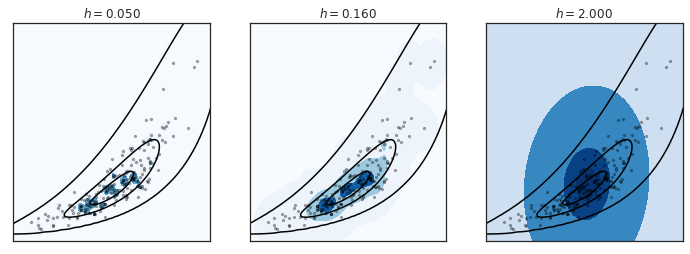

In [50]:
x = np.linspace(-3.5, 3.5, 100)
y = np.linspace(0.1, 4, 100)
X, Y = np.meshgrid(x, y)
Z = multinorm.pdf(np.dstack((X, np.log(Y))))
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(12, 4))
kdes = [kde_narrow, kde_right, kde_wide]
for i, kde in enumerate(kdes):
    plt.subplot(1, len(kdes), i+1)
    Z_kde = 10**kde.score_samples(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
    levels_kde = [0,
                  np.percentile(Z_kde.flatten(), 68),
                  np.percentile(Z_kde.flatten(), 95),
                  np.percentile(Z_kde.flatten(), 99),
                  np.max(Z_kde)]
    plt.contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
    plt.contour(X, Y, Z, levels, colors='k')
    plt.scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
    plt.xlim(-3, 3)
    plt.ylim(0.1, 4)
    plt.title('$h={:0.3f}$'.format(kde.bandwidth))
    plt.xticks([])
    plt.yticks([])
plt.savefig('../figures/2d_scatter_no_scaling.pdf', bbox_inches='tight')

/home/samdixon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/samdixon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


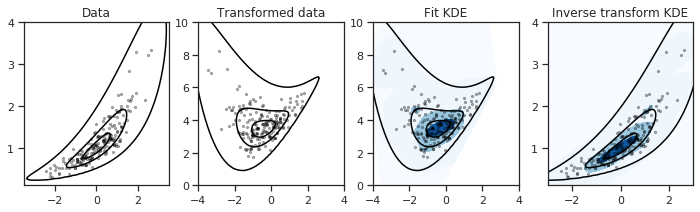

In [51]:
v, l, vinv = np.linalg.svd(np.cov(obs.T))
scaled_obs = (np.diag(1./np.sqrt(l)) @ vinv @ obs.T).T
params = {'bandwidth': np.geomspace(0.05, 2, 20)}
grid = GridSearchCV(KernelDensity(), params, cv=3)
grid.fit(scaled_obs)
scaled_kde = grid.best_estimator_
unscaled_kde = grid.fit(obs).best_estimator_

x = np.linspace(-3.5, 3.5, 100)
y = np.linspace(0.1, 4, 100)
X, Y = np.meshgrid(x, y)
Z = multinorm.pdf(np.dstack((X, np.log(Y))))
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.contour(X, Y, Z, levels, colors='k')
plt.scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
plt.title('Data')

scaled_grid = (np.diag(1./np.sqrt(l)) @ vinv @ np.array([X.flatten(), Y.flatten()])).T
scaled_X, scaled_Y = scaled_grid.T
scaled_X = scaled_X.reshape(X.shape)
scaled_Y = scaled_Y.reshape(Y.shape)

plt.subplot(1, 4, 2)
plt.contour(scaled_X, scaled_Y, Z, levels, colors='k')
plt.scatter(scaled_obs[:, 0], scaled_obs[:, 1], c='k', alpha=0.3, s=5)
plt.xlim(-4, 4)
plt.ylim(0, 10)
plt.title('Transformed data')

plt.subplot(1, 4, 3)
scaled_grid = (np.diag(1./np.sqrt(l)) @ vinv @ np.array([X.flatten(), Y.flatten()])).T
Z_kde = 10**scaled_kde.score_samples(scaled_grid).reshape(X.shape)
levels_kde = [0,
              np.percentile(Z_kde.flatten(), 68),
              np.percentile(Z_kde.flatten(), 95),
              np.percentile(Z_kde.flatten(), 99),
              np.max(Z_kde)]
plt.contour(scaled_X, scaled_Y, Z, levels, colors='k')
plt.contourf(scaled_X, scaled_Y, Z_kde, levels_kde, cmap='Blues')
plt.scatter(scaled_obs[:, 0], scaled_obs[:, 1], c='k', alpha=0.3, s=5)
plt.xlim(-4, 4)
plt.ylim(0, 10)
plt.title('Fit KDE')

plt.subplot(1, 4, 4)
plt.contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
plt.contour(X, Y, Z, levels, colors='k')
plt.scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
plt.xlim(-3, 3)
plt.ylim(0.1, 4)
plt.title('Inverse transform KDE')
plt.savefig('../figures/2d_rescaling_process.pdf', bbox_inches='tight')

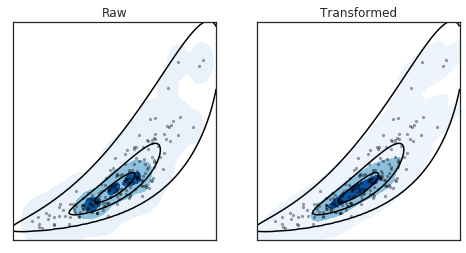

In [52]:
v, l, vinv = np.linalg.svd(np.cov(obs.T))
scaled_obs = (np.diag(1./np.sqrt(l)) @ vinv @ obs.T).T
params = {'bandwidth': np.logspace(-1, 1, 100)}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(scaled_obs)
scaled_kde = grid.best_estimator_
unscaled_kde = grid.fit(obs).best_estimator_

x = np.linspace(-3, 3, 100)
y = np.linspace(0.1, 4, 100)
X, Y = np.meshgrid(x, y)
Z = multinorm.pdf(np.dstack((X, np.log(Y))))
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(8, 4))
for i, kde in enumerate([unscaled_kde, scaled_kde]):
    plt.subplot(1, 2, i+1)
    if kde == scaled_kde:
        scaled_grid = (np.diag(1./np.sqrt(l)) @ vinv @ np.array([X.flatten(), Y.flatten()])).T
        Z_kde = 10**scaled_kde.score_samples(scaled_grid).reshape(X.shape)
        plt.title('Transformed')
    else:
        Z_kde = 10**kde.score_samples(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
        plt.title('Raw')
    levels_kde = [np.percentile(Z_kde.flatten(), 68),
                  np.percentile(Z_kde.flatten(), 95),
                  np.percentile(Z_kde.flatten(), 99),
                  np.max(Z_kde)]
    plt.contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
    plt.contour(X, Y, Z, levels, colors='k')
    plt.scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
    plt.xlim(-3, 3)
    plt.ylim(0.1, 4)
    plt.xticks([])
    plt.yticks([])
plt.savefig('../figures/2d_scatter.pdf', bbox_inches='tight')

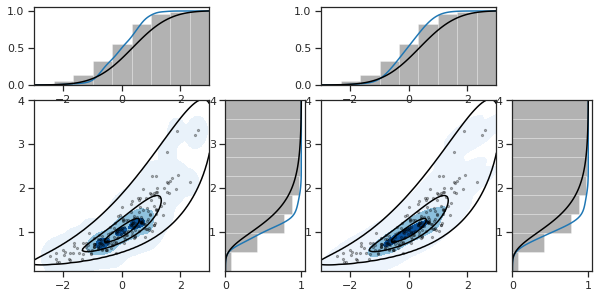

In [53]:
v, l, vinv = np.linalg.svd(np.cov(obs.T))
scaled_obs = (np.diag(1./np.sqrt(l)) @ vinv @ obs.T).T
params = {'bandwidth': np.logspace(-1, 1, 100)}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(scaled_obs)
scaled_kde = grid.best_estimator_
unscaled_kde = grid.fit(obs).best_estimator_

x = np.linspace(-3, 3, 100)
y = np.linspace(0.1, 4, 100)
X, Y = np.meshgrid(x, y)
Z = multinorm.pdf(np.dstack((X, np.log(Y))))
levels = [0,
          np.percentile(Z.flatten(), 68),
          np.percentile(Z.flatten(), 95),
          np.percentile(Z.flatten(), 99),
          np.max(Z)]

plt.figure(figsize=(10, 10))
scatter_axes = [plt.subplot2grid((6, 6), (1, 0), colspan=2, rowspan=2),
                plt.subplot2grid((6, 6), (1, 3), colspan=2, rowspan=2)]
x_axes = [plt.subplot2grid((6, 6), (0, 0), colspan=2),
          plt.subplot2grid((6, 6), (0, 3), colspan=2)]
y_axes = [plt.subplot2grid((6, 6), (1, 2), rowspan=2),
          plt.subplot2grid((6, 6), (1, 5), rowspan=2)]

for i, kde in enumerate([unscaled_kde, scaled_kde]):
    if kde == scaled_kde:
        scaled_grid = (np.diag(1./np.sqrt(l)) @ vinv @ np.array([X.flatten(), Y.flatten()])).T
        Z_kde = 10**scaled_kde.score_samples(scaled_grid).reshape(X.shape)
    else:
        Z_kde = 10**kde.score_samples(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
    levels_kde = [np.percentile(Z_kde.flatten(), 68),
                  np.percentile(Z_kde.flatten(), 95),
                  np.percentile(Z_kde.flatten(), 99),
                  np.max(Z_kde)]
    scatter_axes[i].contourf(X, Y, Z_kde, levels=levels_kde, cmap='Blues')
    scatter_axes[i].contour(X, Y, Z, levels, colors='k')
    scatter_axes[i].scatter(obs[:, 0], obs[:, 1], c='k', alpha=0.3, s=5)
    
    x_axes[i].hist(obs[:, 0], density=True, color='k', bins=np.linspace(-3, 3, 10),
                   cumulative=True, alpha=0.3)
    x_axes[i].plot(X[0], np.cumsum(Z_kde.sum(axis=0))/Z_kde.sum())
    x_axes[i].plot(X[0], np.cumsum(Z.sum(axis=0))/Z.sum(), color='k')
    
    y_axes[i].hist(obs[:, 1], orientation='horizontal', bins=np.linspace(0.1, 4, 10),
                   density=True, cumulative=True, color='k', alpha=0.3)
    y_axes[i].plot(np.cumsum(Z_kde.sum(axis=1))/Z_kde.sum(), Y[:, 0])
    y_axes[i].plot(np.cumsum(Z.sum(axis=1))/Z.sum(), Y[:, 0], color='k')
    scatter_axes[i].set_xlim(-3, 3)
    scatter_axes[i].set_ylim(0.1, 4)
    y_axes[i].set_ylim(0.1, 4)
    x_axes[i].set_xlim(-3, 3)
#     scatter_axes[i].set_xticks([])
#     scatter_axes[i].set_yticks([])
#     x_axes[i].set_xticks([])
#     x_axes[i].set_yticks([])
#     y_axes[i].set_xticks([])
#     y_axes[i].set_yticks([])
plt.savefig('../figures/2d_scatter_with_marginal.pdf', bbox_inches='tight')